In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 2 to use

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')
# tf.debugging.set_log_device_placement(False)

2024-07-05 11:39:10.837873: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 11:39:10.975416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 11:39:10.975475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 11:39:10.975586: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 11:39:11.039152: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1


2024-07-05 11:39:13.758294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 11:39:13.905237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 11:39:13.905506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
from keras.utils import Sequence
import os
import random
import ecdsa
import sha3
import matplotlib.pyplot as plt

In [4]:
def private_key_to_public_key(private_key_hex):
    private_key_bytes = bytes.fromhex(private_key_hex)
    sk = ecdsa.SigningKey.from_string(private_key_bytes, curve=ecdsa.SECP256k1)
    vk = sk.verifying_key
    public_key_bytes = b'\x04' + vk.to_string()  # Add the constant prefix 0x04
    return public_key_bytes.hex()

def public_key_to_address(public_key_hex):
    public_key_bytes = bytes.fromhex(public_key_hex)
    keccak = sha3.keccak_256()
    keccak.update(public_key_bytes[1:])  # Remove the prefix 0x04
    return '0x' + keccak.hexdigest()[24:]  # Last 20 bytes (40 hex characters)

def main():
    private_key = "0000000000000000000000000333885fa2fea99a9c720e77b7da7e3ebe2a9a58"  # Replace with your Ethereum private key
    public_key = private_key_to_public_key(private_key)
    address = public_key_to_address(public_key)
    print(f"Private Key: {private_key}")
    print(f"Public Key: {public_key}")
    print(f"Address: {address}")

main()

Private Key: 0000000000000000000000000333885fa2fea99a9c720e77b7da7e3ebe2a9a58
Public Key: 046e12973d5aae936764d876f81b7b6b13032c8c3001b072690d1386dfb0f93cbbf21ef7a79a704bde6d6a828bccfe30d03236fd364c6320b3eb4609fe193e16bd
Address: 0x208bd6b033273034681f774580389921d8b428f4


In [41]:
tmp = np.array([1,2,3,4,5])
print(tmp.dtype)
tmp = tmp.astype(np.float64)
print(tmp.dtype)
tmp[tmp>3] = 10
print(tmp)

int64
float64
[ 1.  2.  3. 10. 10.]


In [48]:
class CustomDataGenerator(Sequence):
    def __init__(self, st, en, batch_size, shuffle=True):
        self.st = st
        self.en = en
        self.total = en-st
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # 한 epoch 당 배치의 수를 반환합니다.
        return int(np.floor(self.total / self.batch_size))

    def __getitem__(self, index):
        # 배치 단위로 데이터를 로드하고 반환합니다.
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_private = np.array([self.make_private(i) for i in batch_indices])
        batch_public = np.array([self.make_public(i) for i in batch_private])
        batch_private = batch_private.astype(np.float32)
        batch_private[batch_private == 1] = 0.9
        batch_private[batch_private == 0] = 0.1

        return batch_public, batch_private
    
    def make_private(self, seed):
        random.seed(seed)
        key = []
        for i in range(1,257):
            if i <= 100:
                key.append(0)
            else:
                key.append(random.randint(0,1))
        return np.array(key)
    
    def make_public(self, key):
        private=""
        for i in range(0,256,4):
            tmp = key[i]*8+key[i+1]*4+key[i+2]*2+key[i+3]
            if tmp<10 :
                private+=str(tmp)
            else:
                private+=chr(tmp-10+97)

        public = self.private_key_to_public_key(private)
        address = self.public_key_to_address(public)
        
        public_list = []
        for i in public:
            val=ord(i)
            if val>=48 and val<=57:
                val-=48
            else:
                val=val-97+10
            
            public_list.append(val//8)
            val%=8
            public_list.append(val//4)
            val%=4
            public_list.append(val//2)
            val%=2
            public_list.append(val//1)
            val%=1
        
        return np.array(public_list)
    
    def private_key_to_public_key(self, private_key_hex):
        private_key_bytes = bytes.fromhex(private_key_hex)
        sk = ecdsa.SigningKey.from_string(private_key_bytes, curve=ecdsa.SECP256k1)
        vk = sk.verifying_key
        public_key_bytes = b'\x04' + vk.to_string()  # Add the constant prefix 0x04
        return public_key_bytes.hex()

    def public_key_to_address(self, public_key_hex):
        public_key_bytes = bytes.fromhex(public_key_hex)
        keccak = sha3.keccak_256()
        keccak.update(public_key_bytes[1:])  # Remove the prefix 0x04
        return '0x' + keccak.hexdigest()[24:]  # Last 20 bytes (40 hex characters)

    def on_epoch_end(self):
        # epoch이 끝날 때마다 데이터 인덱스를 셔플합니다.
        self.indices = np.arange(self.st, self.en)
        if self.shuffle:
            np.random.shuffle(self.indices)


In [49]:
random.seed(3)
key = []
for i in range(1,257):
    if i <= 100:
        key.append(0)
    else:
        key.append(random.randint(0,1))
key = np.array(key)
print(key)

v=""
for i in range(0,256,4):
    tmp = key[i]*8+key[i+1]*4+key[i+2]*2+key[i+3]
    if tmp<10 :
        v+=str(tmp)
    else:
        v+=chr(tmp-10+97)
print(v)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1
 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0
 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0
 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1
 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0]
0000000000000000000000000333885fa2fea99a9c720e77b7da7e3ebe2a9a58


In [57]:
train_generator = CustomDataGenerator(0,100000, 1000, True)
test_generator = CustomDataGenerator(100000,103000, 1000, True)

In [58]:
train, label = train_generator[0]
print(train.shape)
print(label)

/tmp/ipykernel_129756/1696526052.py:26: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


(1000, 520)
[[0.1 0.1 0.1 ... 0.1 0.1 0.9]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 ...
 [0.1 0.1 0.1 ... 0.1 0.1 0.9]
 [0.1 0.1 0.1 ... 0.9 0.9 0.9]
 [0.1 0.1 0.1 ... 0.1 0.9 0.1]]


In [59]:
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model

input = Input(shape=(520,))
d1 = Dense(750, activation="relu")(input)
b1 = BatchNormalization()(d1)
d2 = Dense(1000, activation="relu")(b1)
b2 = BatchNormalization()(d2)
d3 = Dense(700, activation="relu")(b2)
b3 = BatchNormalization()(d3)
d4 = Dense(500, activation="relu")(b3)
b4 = BatchNormalization()(d4)
d5 = Dense(350, activation="relu")(b4)
b5 = BatchNormalization()(d5)
d6 = Dense(256, activation="sigmoid")(b5)
model = Model(input, d6)

In [60]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 520)]             0         
                                                                 
 dense_16 (Dense)            (None, 750)               390750    
                                                                 
 batch_normalization_14 (Ba  (None, 750)               3000      
 tchNormalization)                                               
                                                                 
 dense_17 (Dense)            (None, 1000)              751000    
                                                                 
 batch_normalization_15 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_18 (Dense)            (None, 700)               7007

In [61]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
history = model.fit(
    train_generator,
    epochs=40,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator
)

/tmp/ipykernel_129756/1696526052.py:26: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


Epoch 1/40
100/100 [==============================] - 49s 452ms/step - loss: 0.6358 - accuracy: 0.0045 - val_loss: 0.5515 - val_accuracy: 3.3333e-04
Epoch 2/40
100/100 [==============================] - 46s 455ms/step - loss: 0.5498 - accuracy: 0.0088 - val_loss: 0.5499 - val_accuracy: 0.0133
Epoch 3/40
100/100 [==============================] - 46s 462ms/step - loss: 0.5496 - accuracy: 0.0038 - val_loss: 0.5497 - val_accuracy: 3.3333e-04
Epoch 4/40
100/100 [==============================] - 46s 456ms/step - loss: 0.5494 - accuracy: 0.0202 - val_loss: 0.5497 - val_accuracy: 0.0013
Epoch 5/40
100/100 [==============================] - 44s 443ms/step - loss: 0.5490 - accuracy: 0.0074 - val_loss: 0.5500 - val_accuracy: 0.0053
Epoch 6/40
100/100 [==============================] - 44s 442ms/step - loss: 0.5485 - accuracy: 0.0074 - val_loss: 0.5503 - val_accuracy: 0.0013
Epoch 7/40
100/100 [==============================] - 45s 446ms/step - loss: 0.5477 - accuracy: 0.0057 - val_loss: 0.5513 

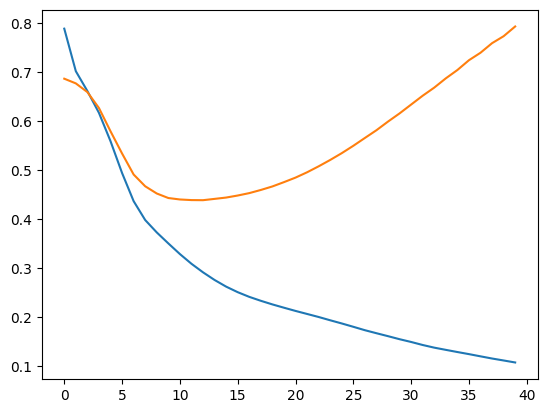

In [13]:
# print(history.history["loss"])
plt.plot(range(40),history.history["loss"][:130])
plt.plot(range(40),history.history["val_loss"][:130])
plt.show()

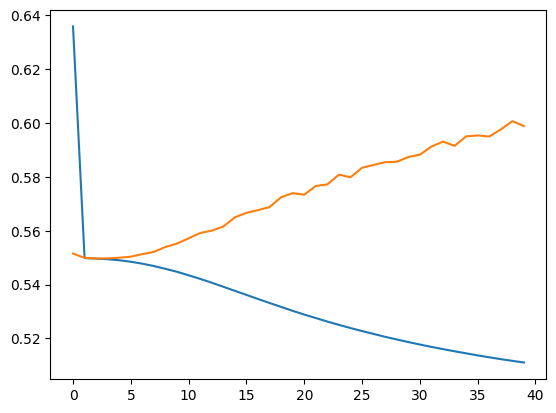

In [63]:
# print(history.history["loss"])
plt.plot(range(40),history.history["loss"][:130])
plt.plot(range(40),history.history["val_loss"][:130])
plt.show()

In [26]:
print(train_generator[0])
model.predict(train_generator[0][0])

(array([[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        

/tmp/ipykernel_58195/1138645872.py:23: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  